# COBAR 2023 Locomotion Code Submission

Please use this template to submit your code for your COBAR miniproject.

**PLEASE READ THE INSTRUCTIONS BELOW CAREFULLY.**

**Google Colab:** It is your responsibility to make sure that your code can be executed without error on Google Colab. You may use your own machine for development, but in the end we will use Colab to determine whether your code runs. You need to select a GPU instance on Google Colab for this notebook. Go to "Runtime" > "Change runtime type", select "GPU" under "Hardware accelerator" and click "Save."

**Where to put your code:** Please only fill your code in places indicated by the following. These cells are provided flexibly enough, and you should be able to easily add your custom import/loading/preprocessing/stepping code. You may also use common `*.py` module files and import functions/classes from these modules.
```Python
# ========== YOUR CODE BELOW ==========
... write your code here
# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^
```

**Terrain types:** Once you have completed this notebook for flat terrain, duplicate 2 more copies of this notebook, and change the terrain type to "gapped" and "blocks" respectively. Make sure you can run all three notebooks on Colab.

**Stabilization time:** Recall from the decentralized control demo: it might be helpful to first run a number of steps (`n_steps_stabil`) without locomotion so the fly has a chance to stabilize on the ground. This is allowed and does not count toward the 1-second simulation time.

**What to submit:** Please submit the following files via Moodle:
1. The three *executed* notebooks (ie. the outputs of the code blocks are printed). Name these files "submission_flat.ipynb", "submission_gapped.ipynb", and "submission_blocks.ipynb"
2. The three output videos: "output_flat.mp4", "output_gapped.mp4", and "output_blocks.mp4"
3. Any data file that are required for the notebooks to run (eg. parameter files, additional configurations, ...). In other words, include any file that you are loading to the notebooks. We will download these files to the same directory/folder as the notebook files before running the notebooks.
4. If you have any `*.py` module file from which you imported variables, functions, or classes, included these files too.

---

In [1]:
# #@title Install `flygym` on Colab

# # This block is modified from dm_control's tutorial notebook
# # https://github.com/deepmind/dm_control/blob/main/tutorial.ipynb

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    import subprocess
    if subprocess.run('nvidia-smi').returncode:
        raise RuntimeError(
            'Cannot communicate with GPU. '
            'Make sure you are using a GPU Colab runtime. '
            'Go to the Runtime menu and select Choose runtime type.')

    print('Installing flygym')
    !pip install -q --progress-bar=off 'flygym[mujoco] @ git+https://github.com/NeLy-EPFL/flygym.git'

    # Configure dm_control to use the EGL rendering backend (requires GPU)
    %env MUJOCO_GL=egl

    print('Checking that the dm_control installation succeeded...')
    try:
        from dm_control import suite
        env = suite.load('cartpole', 'swingup')
        pixels = env.physics.render()
    except Exception as e:
        raise e from RuntimeError(
            'Something went wrong during dm_control installation. Check the shell '
            'output above for more information.\n'
            'If using a hosted Colab runtime, make sure you enable GPU acceleration '
            'by going to the Runtime menu and selecting "Choose runtime type".')
    else:
        del pixels, suite

    print('Checking that the flygym installation succeeded...')
    try:
        import flygym
        from flygym import envs
    except Exception as e:
        raise e from RuntimeError(
            'Something went wrong during flygym installation. Check the shell '
            'output above for more information.\n')
    else:
        del envs, flygym
else:
    print('Skipping - not on Colab')

Skipping - not on Colab


You may install any additional packages here with pip. NumPy should already be installed; it's merely a demonstration of the syntax.

In [2]:
# ========== YOUR CODE BELOW ==========
!pip install numpy
# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^

The following are some of the modules imported in the demo notebooks:

In [3]:
import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo
from tqdm import trange
from flygym.util.config import all_leg_dofs

You may import any additional modules here:

In [4]:
# ========== YOUR CODE BELOW ==========

# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^

We select the terrain type here. **YOUR CODE MUST STILL WORK IF THIS IS CHANGED TO gapped OR blocks!**

In [5]:
terrain_type = 'flat'  # or 'gapped' or 'blocks'

We define some other physics parameters. Thess must not be changed.

In [6]:
# You are allowed to slightly change the initial position of the fly
# if it immediately gets stuck due to unfortunate initial placement
# ========== YOUR CODE BELOW ==========
fly_pos = (0, 0, 300)
# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^

run_time = 1
out_dir = Path(f'contest_submission_{terrain_type}')

friction = 1.0

physics_config = {
    'joint_stiffness': 2500,
    'friction': (friction, 0.005, 0.0001),
    'gravity': (0, 0, -9.81e5)}
terrain_config = {'fly_pos': fly_pos,
                  'friction': (friction, 0.005, 0.0001)}

You may load any preprogrammed data here and manipulate them as needed. This can include reference step kinematics (as used in the decentralized control and centralized control notebooks), or parameter files for your artificial neural network:

In [7]:
# ========== YOUR CODE BELOW ==========
# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
with open(data_path / 'behavior' / 'single_steps.pkl', 'rb') as f:
    data = pickle.load(f)

# Interpolate 5x
target_timestep = 1e-4
num_steps_base = int(run_time / target_timestep)
step_duration = len(data['joint_LFCoxa'])
interp_step_duration = int(step_duration * data['meta']['timestep'] / target_timestep)
step_data_block_base = np.zeros((len(all_leg_dofs), interp_step_duration))
measure_t = np.arange(step_duration) * data['meta']['timestep']
interp_t = np.arange(interp_step_duration) * target_timestep
for i, joint in enumerate(all_leg_dofs):
    step_data_block_base[i, :] = np.interp(interp_t, measure_t, data[joint])
    
# Load manual adjustment data
with open("manual_corrected_data.pickle", 'rb') as f:
    step_data_block_manualcorrect, leg_swing_starts, leg_stance_starts, n_steps_stabil = pickle.load(f)
    
# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^

Next, initiate your NeuroMechFly simulation environment.

In [8]:
# ========== YOUR CODE BELOW ==========
nmf = NeuroMechFlyMuJoCo(
    terrain=terrain_type,
    render_mode='saved',
    timestep=1e-4,
    render_config={'playspeed': 0.1, 'camera': 'Animat/camera_left_top'},
    init_pose='stretch',
    actuated_joints=all_leg_dofs
)
# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^

You can add arbitrary code here after initializing the `nmf` object and before running the simulation loop:

In [9]:
# ========== YOUR CODE BELOW ==========
# Initialize simulation
n_stabilisation_steps = n_steps_stabil
# Run the simulation for a few steps to stabilise the system before starting the contoller
num_steps = num_steps_base + n_stabilisation_steps

#Define rule variables
legs = ["RF", "LF", "RM", "LM", "RH", "LH"]
leg_ids = np.arange(len(legs)).astype(int)
leg_corresp_id = dict(zip(legs, leg_ids))
n_joints = len(nmf.actuated_joints)
joint_ids = np.arange(n_joints).astype(int)
match_leg_to_joints = np.array([i  for joint in nmf.actuated_joints for i, leg in enumerate(legs) if leg in joint])

rule1_corresponding_legs = {"LH":["LM"], "LM":["LF"], "LF":[], "RH":["RM"], "RM":["RF"], "RF":[]}
rule2_corresponding_legs = {"LH":["LM", "RH"], "LM":["LF", "RM"], "LF":["RF"], "RH":["RM", "LH"], "RM":["RF", "LM"], "RF":["LF"]}
rule3_corresponding_legs = {"LH":["RH"], "LM":["LH", "RM"], "LF":["LM", "RF"], "RH":["LH"], "RM":["RH", "LM"], "RF":["LF", "RM"]}

#Rule 1 should supress lift off (if a leg is in swing coupled legs should not be lifted most important leg to guarantee stability)
rule1_weight = -1e4
#Rule 2 should facilitate early protraction (upon touchdown of a leg coupled legs are encouraged to swing)
rule2_weight = 2.5
rule2_weight_contralateral = 1
#Rule 3 should enforce late protraction (the later in the stance the more it facilitates stance initiation)
rule3_weight = 3
rule3_weight_contralateral = 2

# This represents the score of each leg in the current step
leg_scores = np.zeros(len(legs))
all_leg_scores = np.zeros((len(legs), num_steps))

# Monitor the evolution of each part of the score for each leg
all_legs_rule1_scores = np.zeros((len(legs), num_steps))
all_legs_rule2_scores = np.zeros((len(legs), num_steps))
all_legs_rule3_scores = np.zeros((len(legs), num_steps))

# one percent margin if leg score within this margin to the max score random choice between the very likely legs
percent_margin = 0.001

# For each leg the ids of the force sensors that are attached to it
leg_force_sensors_ids = {leg:[] for leg in legs}
for i, collision_geom in enumerate(nmf.collision_tracked_geoms):
    for leg in legs:
        if collision_geom.startswith(leg):
            leg_force_sensors_ids[leg].append(i)


def update_stepping_advancement(stepping_advancement, legs, interp_step_duration):
    # Advance the stepping advancement of each leg that are stepping, reset the advancement of the legs that are done stepping
    for k, leg in enumerate(legs):
        if stepping_advancement[k] >= interp_step_duration-1:
            stepping_advancement[k] = 0
        elif stepping_advancement[k] > 0:
            stepping_advancement[k] +=1
    return stepping_advancement

def compute_leg_scores(rule1_corresponding_legs, rule1_weight,
                       rule2_corresponding_legs, rule2_weight, rule2_weight_contralateral,
                       rule3_corresponding_legs, rule3_weight, rule3_weight_contralateral,
                       stepping_advancement, leg_corresp_id, leg_stance_starts, interp_step_duration):
    # Compute the leg scores for the current  timestep based on the rules and the stepping advancement
    # Fills the global variables all_legs_rule1_scores, all_legs_rule2_scores, all_legs_rule3_scores, all_leg_scores to monitor the evolution of the score (debugging)
    leg_scores = np.zeros(len(legs))
    
    #Iterate through legs to compute score
    for k, leg in enumerate(legs):        
        # For the first rule
        leg_scores[[leg_corresp_id[l] for l in rule1_corresponding_legs[leg]]] += rule1_weight*(stepping_advancement[k]>0 and stepping_advancement[k]<leg_stance_starts[leg]).astype(float)
        all_legs_rule1_scores[[leg_corresp_id[l] for l in rule1_corresponding_legs[leg]], i] += rule1_weight*(stepping_advancement[k]>0 and stepping_advancement[k]<leg_stance_starts[leg]).astype(float)       
        
        #For the second rule strong contact force happens at the beggining of the stance phase
        for l in rule2_corresponding_legs[leg]:
            #Decrease with stepping advancement
            if l[0] == leg[0]:
                #ipsilateral leg
                leg_scores[leg_corresp_id[l]] += rule2_weight*((interp_step_duration - leg_stance_starts[leg])-(stepping_advancement[k] - leg_stance_starts[leg])) if (stepping_advancement[k] - leg_stance_starts[leg])>0 else 0
                all_legs_rule2_scores[leg_corresp_id[l], i] += rule2_weight*((interp_step_duration - leg_stance_starts[leg])-(stepping_advancement[k] - leg_stance_starts[leg])) if (stepping_advancement[k] - leg_stance_starts[leg])>0 else 0
            else:
                #contralateral leg
                leg_scores[leg_corresp_id[l]] += rule2_weight_contralateral*((interp_step_duration - leg_stance_starts[leg])-(stepping_advancement[k] - leg_stance_starts[leg])) if (stepping_advancement[k] - leg_stance_starts[leg])>0 else 0
                all_legs_rule2_scores[leg_corresp_id[l], i] += rule2_weight_contralateral*((interp_step_duration - leg_stance_starts[leg])-(stepping_advancement[k] - leg_stance_starts[leg])) if (stepping_advancement[k] - leg_stance_starts[leg])>0 else 0

        #For the third rule
        for l in rule3_corresponding_legs[leg]:
            #Increase with stepping advancement
            if l[0] == leg[0]:
                leg_scores[leg_corresp_id[l]] += rule3_weight*((stepping_advancement[k] - leg_stance_starts[leg])) if (stepping_advancement[k] - leg_stance_starts[leg])>0 else 0
                all_legs_rule3_scores[leg_corresp_id[l], i] += rule3_weight*((stepping_advancement[k] - leg_stance_starts[leg])) if (stepping_advancement[k] - leg_stance_starts[leg])>0 else 0
            else:
                leg_scores[leg_corresp_id[l]] += rule3_weight_contralateral*((stepping_advancement[k] - leg_stance_starts[leg])) if (stepping_advancement[k] - leg_stance_starts[leg])>0 else 0
                all_legs_rule3_scores[leg_corresp_id[l], i] += rule3_weight_contralateral*((stepping_advancement[k] - leg_stance_starts[leg])) if (stepping_advancement[k] - leg_stance_starts[leg])>0 else 0

    return leg_scores

# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^

Now, run the simulation:

In [10]:
# Final preparation here
# ========== YOUR CODE BELOW ==========

np.random.seed(42)

# This serves to keep track of the advancement of each leg in the stepping sequence
stepping_advancement = np.zeros(len(legs)).astype(int)

# Track the number of steps taken. It will be used to determine the stpping probability in the random stepper
number_of_taken_steps = 0
leg_scores = np.zeros(len(legs))

obs_list_cruse_flat = []
all_initiated_legs = []

# ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^

nmf.reset()
x_pos_hist = []

# Main simulation loop
for i in trange(num_steps):
    # You may insert any code before stepping the physics simulation...
    # ========== YOUR CODE BELOW ==========
    # Decide in which leg to step
    initiating_leg = np.argmax(leg_scores)
    within_margin_legs = leg_scores[initiating_leg]-leg_scores <= leg_scores[initiating_leg]*percent_margin

    # If multiple legs are within the margin choose randomly among those legs
    if np.sum(within_margin_legs) > 1:
        initiating_leg = np.random.choice(np.where(within_margin_legs)[0])

    # If the maximal score is zero or less (except for the first step after stabilisation to initate the locomotion) or if the leg is already stepping
    if (leg_scores[initiating_leg] <= 0 and not i == n_stabilisation_steps+1) or stepping_advancement[initiating_leg] > 0:
        initiating_leg = None
    else:
        stepping_advancement[initiating_leg] += 1
        all_initiated_legs.append([initiating_leg, i])
        number_of_taken_steps += 1
        #print("Stepping leg: ", legs[initiating_leg], " at step: ", i)
    
    joint_pos = step_data_block_manualcorrect[joint_ids, stepping_advancement[match_leg_to_joints]]
    action = {'joints': joint_pos}
    # ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^
    
    obs, info = nmf.step(action)
    nmf.render()
    
    # ... and after stepping the physics simulation
    # ========== YOUR CODE BELOW ==========
    obs_list_cruse_flat.append(obs)

    stepping_advancement = update_stepping_advancement(stepping_advancement, legs, interp_step_duration)

    leg_scores = compute_leg_scores(rule1_corresponding_legs, rule1_weight,
                                    rule2_corresponding_legs, rule2_weight, rule2_weight_contralateral,
                                    rule3_corresponding_legs, rule3_weight, rule3_weight_contralateral,
                                    stepping_advancement, leg_corresp_id, leg_stance_starts, interp_step_duration)
        
    all_leg_scores[:, i] = leg_scores
    # ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^
    
    # Report the final x position of the base of the fly here. If you wrote
    # a wrapper around `NeuroMechFlyMuJoCo` (for your own RL pipeline, for
    # example), you may modify the code below to faithfully report the final
    # x position of the base of the fly depending on your implementation.
    # Obviously, don't hard code a very large number :)
    # ========== YOUR CODE BELOW ==========
    current_x_pos = obs['fly'][0, 0]
    # ^^^^^^^^^^ END OF YOUR CODE ^^^^^^^^^
    x_pos_hist.append(current_x_pos)

# Save video here. SUBMIT THIS VIDEO ALONG WITH THE CODE!
nmf.save_video(out_dir / f"output_{terrain_type}.mp4")

nmf.close()


100%|██████████████████████████████████████████████| 14800/14800 [00:34<00:00, 428.85it/s]


The video should have been saved to `out_dir / f"output_{terrain_type}.mp4"`. Check that it makes sense.

Finally, let's visualize how the fly's x position changes over time:

Final position: 6.5018 mm


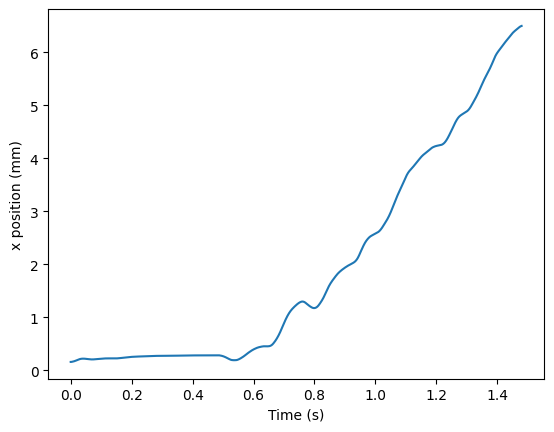

In [11]:
plt.plot(np.arange(num_steps) * nmf.timestep, np.array(x_pos_hist) / 1000)
plt.xlabel('Time (s)')
plt.ylabel('x position (mm)')
print(f'Final position: {x_pos_hist[-1] / 1000:.4f} mm')